# Reinforcement Learning Projet

**Athors** : Yassine Filali, Mohamed Farhat and Mohamed El Khames Boumaiza

In [7]:
#Importing necessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import copy
import torch.optim as optim
import matplotlib.pyplot as plt

Implementation of the class State

In [8]:
class State:
  def __init__(self):
        self.tictactoe = State_tictactoe 
        

Implementation of a simple game: Tic-Tac-Toe

In [9]:
class State_tictactoe:
    X, Y = 'ABC',  '123'
    C = {0: '_', 1: 'O', -1: 'X'}

    def __init__(self):
        self.board = np.zeros((3, 3)) 
        self.color = 1
        self.win_color = 0
        self.record = []
        self.BLACK = 1  # first turn
        self.WHITE = -1 #second turn player

    def action2str(self, a):
        return self.X[a // 3] + self.Y[a % 3]

    def str2action(self, s):
        return self.X.find(s[0]) * 3 + self.Y.find(s[1])

    def record_string(self):
        return ' '.join([self.action2str(a) for a in self.record])

    def __str__(self):
        # output board.
        s = '   ' + ' '.join(self.Y) + '\n'
        for i in range(3):
            s += self.X[i] + ' ' + ' '.join([self.C[self.board[i, j]] for j in range(3)]) + '\n'
        s += 'record = ' + self.record_string()
        return s

    def play(self, action):
        # state transition function
        # action is position inerger (0~8) or string representation of action sequence
        if isinstance(action, str):
            for astr in action.split():
                self.play(self.str2action(astr))
            return self

        x, y = action // 3, action % 3
        self.board[x, y] = self.color

        # check whether 3 stones are on the line
        if self.board[x, :].sum() == 3 * self.color \
          or self.board[:, y].sum() == 3 * self.color \
          or (x == y and np.diag(self.board, k=0).sum() == 3 * self.color) \
          or (x == 2 - y and np.diag(self.board[::-1,:], k=0).sum() == 3 * self.color):
            self.win_color = self.color

        self.color = -self.color
        self.record.append(action)
        return self

    def terminal(self):
        # terminal state check
        return self.win_color != 0 or len(self.record) == 3 * 3

    def terminal_reward(self):
        # terminal reward 
        return self.win_color if self.color == self.BLACK else -self.win_color

    def legal_actions(self):
        # list of legal actions on each state
        return [a for a in range(3 * 3) if self.board[a // 3, a % 3] == 0]

    def feature(self):
        # input tensor for neural net (state)
        return np.stack([self.board == self.color, self.board == -self.color]).astype(np.float32)

    def action_feature(self, action):
        # input tensor for neural net (action)
        a = np.zeros((1, 3, 3), dtype=np.float32)
        a[0, action // 3, action % 3] = 1
        return a

An example

In [10]:
state_ttt = State().tictactoe()
print("Example 1 : ")
action = 'A1 A2'
state = state_ttt.play(action)
print(state)
print('Input feature after playing', action)
print(state.feature())

print("Example 2 : ")
action = 'B1 A2 A1 B3'
state = state_ttt.play(action)
print(state)
print('Input feature after playing', action)
print(state.feature())


Example 1 : 
   1 2 3
A O X _
B _ _ _
C _ _ _
record = A1 A2
Input feature after playing A1 A2
[[[1. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 1. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]]
Example 2 : 
   1 2 3
A O X _
B O _ X
C _ _ _
record = A1 A2 B1 A2 A1 B3
Input feature after playing B1 A2 A1 B3
[[[1. 0. 0.]
  [1. 0. 0.]
  [0. 0. 0.]]

 [[0. 1. 0.]
  [0. 0. 1.]
  [0. 0. 0.]]]


Small Convolutional neural network using PyTorch

In [11]:
# 
class Conv(nn.Module):
    def __init__(self, filters0, filters1, kernel_size, bn=False):
        super().__init__()
        self.conv = nn.Conv2d(filters0, filters1, kernel_size, stride=1, padding=kernel_size//2, bias=False)
        self.bn = None
        if bn:
            self.bn = nn.BatchNorm2d(filters1)

    def forward(self, x):
        h = self.conv(x)
        if self.bn is not None:
            h = self.bn(h)
        return h

class ResidualBlock(nn.Module):
    def __init__(self, filters):
        super().__init__()
        self.conv = Conv(filters, filters, 3, True)

    def forward(self, x):
        return F.relu(x + (self.conv(x)))


In [12]:
num_filters = 16
num_blocks = 4

class Representation(nn.Module):
    ''' Conversion from observation to inner abstract state '''
    def __init__(self, input_shape):
        super().__init__()
        self.input_shape = input_shape
        self.board_size = self.input_shape[1] * self.input_shape[2]

        self.layer0 = Conv(self.input_shape[0], num_filters, 3, bn=True)
        self.blocks = nn.ModuleList([ResidualBlock(num_filters) for _ in range(num_blocks)])

    def forward(self, x):
        h = F.relu(self.layer0(x))
        for block in self.blocks:
            h = block(h)
        return h

    def inference(self, x):
        self.eval()
        with torch.no_grad():
            rp = self(torch.from_numpy(x).unsqueeze(0))
        return rp.cpu().numpy()[0]

class Prediction(nn.Module):
    ''' Policy and value prediction from inner abstract state '''
    def __init__(self, action_shape):
        super().__init__()
        self.board_size = np.prod(action_shape[1:])
        self.action_size = action_shape[0] * self.board_size

        self.conv_p1 = Conv(num_filters, 4, 1, bn=True)
        self.conv_p2 = Conv(4, 1, 1)

        self.conv_v = Conv(num_filters, 4, 1, bn=True)
        self.fc_v = nn.Linear(self.board_size * 4, 1, bias=False)

    def forward(self, rp):
        h_p = F.relu(self.conv_p1(rp))
        h_p = self.conv_p2(h_p).view(-1, self.action_size)

        h_v = F.relu(self.conv_v(rp))
        h_v = self.fc_v(h_v.view(-1, self.board_size * 4))

        # range of value is -1 ~ 1
        return F.softmax(h_p, dim=-1), torch.tanh(h_v)

    def inference(self, rp):
        self.eval()
        with torch.no_grad():
            p, v = self(torch.from_numpy(rp).unsqueeze(0))
        return p.cpu().numpy()[0], v.cpu().numpy()[0][0]

class Dynamics(nn.Module):
    '''Abstract state transition'''
    def __init__(self, rp_shape, act_shape):
        super().__init__()
        self.rp_shape = rp_shape
        self.layer0 = Conv(rp_shape[0] + act_shape[0], num_filters, 3, bn=True)
        self.blocks = nn.ModuleList([ResidualBlock(num_filters) for _ in range(num_blocks)])

    def forward(self, rp, a):
        h = torch.cat([rp, a], dim=1)
        h = self.layer0(h)
        for block in self.blocks:
            h = block(h)
        return h

    def inference(self, rp, a):
        self.eval()
        with torch.no_grad():
            rp = self(torch.from_numpy(rp).unsqueeze(0), torch.from_numpy(a).unsqueeze(0))
        return rp.cpu().numpy()[0]

class Net(nn.Module):
    '''Whole net'''
    def __init__(self,state):
        super().__init__()
        #state = State()
        input_shape = state.feature().shape
        action_shape = state.action_feature(0).shape
        rp_shape = (num_filters, *input_shape[1:])

        self.representation = Representation(input_shape)
        self.prediction = Prediction(action_shape)
        self.dynamics = Dynamics(rp_shape, action_shape)

    def predict(self, state0, path):
        '''Predict p and v from original state and path'''
        outputs = []
        x = state0.feature()
        rp = self.representation.inference(x)
        outputs.append(self.prediction.inference(rp))
        for action in path:
            a = state0.action_feature(action)
            rp = self.dynamics.inference(rp, a)
            outputs.append(self.prediction.inference(rp))
        return outputs

In [13]:
def show_net(net, state):
    '''Display policy (p) and value (v)'''
    print(state)
    p, v = net.predict(state, [])[-1]
    print('policy p = ')
    print((p * 1000).astype(int).reshape((-1, *net.representation.input_shape[1:3])))
    print('value v = ', v)
    print()

#  Outputs before training
state = State().tictactoe()
show_net(Net(state),state )

   1 2 3
A _ _ _
B _ _ _
C _ _ _
record = 
policy p = 
[[[111 111 111]
  [111 111 111]
  [111 111 111]]]
value v =  0.0



Implementation of the MCTS (Monte Carlo Tree Search)

In [14]:
class Tree:
    def __init__(self, net):
        self.net = net
        self.nodes = {}

    def search(self, state, path, rp, depth):
        # Return the predicted value from the new state
        key = state.record_string()
        if len(path) > 0:
            key += '|' + ' '.join(map(state.action2str, path))
        if key not in self.nodes:
            p, v = self.net.prediction.inference(rp)
            self.nodes[key] = Node(p, v)
            return v

        # State transition by an action selected from bandit
        node = self.nodes[key]
        p = node.p
        mask = np.zeros_like(p)
        if depth == 0:
            # Add noise to policy on the root node
            p = 0.75 * p + 0.25 * np.random.dirichlet([0.15] * len(p))
            # On the root node, we choose action only from legal actions
            mask[state.legal_actions()] = 1
            p *= mask
            p /= p.sum() + 1e-16

        n, q_sum = 1 + node.n, node.q_sum_all / node.n_all + node.q_sum
        ucb = q_sum / n + 2.0 * np.sqrt(node.n_all) * p / n + mask * 4 # PUCB formula
        best_action = np.argmax(ucb)

        # Search next state by recursively calling this function
        rp_next = self.net.dynamics.inference(rp, state.action_feature(best_action))
        path.append(best_action)
        q_new = -self.search(state, path, rp_next, depth + 1) # With the assumption of changing player by turn
        node.update(best_action, q_new)

        return q_new

    def think(self, state, num_simulations, temperature = 0, show=False):
        # End point of MCTS
        if show:
            print(state)
        start, prev_time = time.time(), 0
        for _ in range(num_simulations):
            self.search(state, [], self.net.representation.inference(state.feature()), depth=0)

            # Display search result on every second
            if show:
                tmp_time = time.time() - start
                if int(tmp_time) > int(prev_time):
                    prev_time = tmp_time
                    root, pv = self.nodes[state.record_string()], self.pv(state)
                    print('%.2f sec. best %s. q = %.4f. n = %d / %d. pv = %s'
                          % (tmp_time, state.action2str(pv[0]), root.q_sum[pv[0]] / root.n[pv[0]],
                             root.n[pv[0]], root.n_all, ' '.join([state.action2str(a) for a in pv])))

        #  Return probability distribution weighted by the number of simulations
        n = root = self.nodes[state.record_string()].n + 1
        n = (n / np.max(n)) ** (1 / (temperature + 1e-8))
        return n / n.sum()

    def pv(self, state):
        # Return principal variation (action sequence which is considered as the best)
        s, pv_seq = copy.deepcopy(state), []
        while True:
            key = s.record_string()
            if key not in self.nodes or self.nodes[key].n.sum() == 0:
                break
            best_action = sorted([(a, self.nodes[key].n[a]) for a in s.legal_actions()], key=lambda x: -x[1])[0][0]
            pv_seq.append(best_action)
            s.play(best_action)
        return pv_seq

class Node:
    '''Search result of one abstract (or root) state'''
    def __init__(self, p, v):
        self.p, self.v = p, v
        self.n, self.q_sum = np.zeros_like(p), np.zeros_like(p)
        self.n_all, self.q_sum_all = 1, v / 2 # prior

    def update(self, action, q_new):
        # Update
        self.n[action] += 1
        self.q_sum[action] += q_new

        # Update overall stats
        self.n_all += 1
        self.q_sum_all += q_new

Search with initialized net

In [15]:
state = State().tictactoe()

tree = Tree(Net(state))
tree.think(state, 100, show=True)

tree = Tree(Net(state))
tree.think(state.play('A1 C1 A2 C2'), 100, show=True)


   1 2 3
A _ _ _
B _ _ _
C _ _ _
record = 
   1 2 3
A O O _
B _ _ _
C X X _
record = A1 C1 A2 C2


array([0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

Training of neural net

In [16]:
batch_size = 32
num_steps = 100

def gen_target(ep, k):
    '''Generate inputs and targets for training'''
    # path, reward, observation, action, policy
    turn_idx = np.random.randint(len(ep[0]))
    ps, vs, ax = [], [], []
    for t in range(turn_idx, turn_idx + k + 1):
        if t < len(ep[0]):
            p = ep[4][t]
            a = ep[3][t]
        else: # state after finishing game
            # p is 0 (loss is 0)
            p = np.zeros_like(ep[4][-1])
            # random action selection
            a = np.zeros(np.prod(ep[3][-1].shape), dtype=np.float32)
            a[np.random.randint(len(a))] = 1
            a = a.reshape(ep[3][-1].shape)
        vs.append([ep[1] if t % 2 == 0 else -ep[1]])
        ps.append(p)
        ax.append(a)
        
    return ep[2][turn_idx], ax, ps, vs

def train(episodes, net, opt):
    '''Train neural net'''
    p_loss_sum, v_loss_sum = 0, 0
    p_loss_l = []
    v_loss_l = []
    net.train()
    k = 4
    for _ in range(num_steps):
        x, ax, p_target, v_target = zip(*[gen_target(episodes[np.random.randint(len(episodes))], k) for j in range(batch_size)])
        x = torch.from_numpy(np.array(x))
        ax = torch.from_numpy(np.array(ax))
        p_target = torch.from_numpy(np.array(p_target))
        v_target = torch.FloatTensor(np.array(v_target))

        # Change the order of axis as [time step, batch, ...]
        ax = torch.transpose(ax, 0, 1)
        p_target = torch.transpose(p_target, 0, 1)
        v_target = torch.transpose(v_target, 0, 1)

        p_loss, v_loss = 0, 0

        # Compute losses for k (+ current) steps
        for t in range(k + 1):
            rp = net.representation(x) if t == 0 else net.dynamics(rp, ax[t - 1])
            p, v = net.prediction(rp)
            p_loss += torch.sum(-p_target[t] * torch.log(p))
            v_loss += torch.sum((v_target[t] - v) ** 2)

        p_loss_sum += p_loss.item()
        v_loss_sum += v_loss.item()

        optimizer.zero_grad()
        (p_loss + v_loss).backward()
        optimizer.step()

    num_train_datum = num_steps * batch_size
    print('p_loss %f v_loss %f' % (p_loss_sum / num_train_datum, v_loss_sum / num_train_datum))
    return net,p_loss_sum, v_loss_sum

# **Battle against random agents**

In [17]:
def vs_random(net, n=100):
    results = {}
    for i in range(n):
        first_turn = i % 2 == 0
        turn = first_turn
        state =  State().tictactoe()
        while not state.terminal():
            if turn:
                p, _ = net.predict(state, [])[-1]
                action = sorted([(a, p[a]) for a in state.legal_actions()], key=lambda x:-x[1])[0][0]
            else:
                action = np.random.choice(state.legal_actions())
            state.play(action)
            turn = not turn
        r = state.terminal_reward() if turn else -state.terminal_reward()
        results[r] = results.get(r, 0) + 1
    return results

Main algorithm of MuZero vs random agent

In [18]:
num_games = 100
num_games_one_epoch = 50
num_simulations = 50

state_ttt = State().tictactoe()
net = Net(state_ttt)
optimizer = optim.SGD(net.parameters(), lr=3e-4, weight_decay=3e-5, momentum=0.8)

# Display battle results as {-1: lose 0: draw 1: win} (for episode generated for training, 1 means that the first player won)
vs_random_sum = vs_random(net)
print('vs_random = ', sorted(vs_random_sum.items()))

episodes = []
result_distribution = {1: 0, 0: 0, -1: 0}
plot_sum=[]
plot_loss = []
plot_value = []

for g in range(num_games):
    # Generate one episode
    record, p_targets, features, action_features = [], [], [], []
    #print(state)

    state = State().tictactoe()
    # temperature using to make policy targets from search results
    temperature = 0.7
    while not state.terminal():
        tree = Tree(net)
        p_target = tree.think(state, num_simulations, temperature)
        p_targets.append(p_target)
        features.append(state.feature())
        # Select action with generated distribution, and then make a transition by that action
        action = np.random.choice(np.arange(len(p_target)), p=p_target)
        action_features.append(state.action_feature(action))
        state.play(action)
        record.append(action)
        temperature *= 0.8
    # reward seen from the first turn player
    reward = state.terminal_reward() * (1 if len(record) % 2 == 0 else -1)
    result_distribution[reward] += 1
    episodes.append((record, reward, features, action_features, p_targets))
    if g % num_games_one_epoch == 0:
        print('game ', end='')
    print(g, ' ', end='')

    # Training of neural net
    if (g + 1) % num_games_one_epoch == 0:
        # Show the result distributiuon of generated episodes
        #print('generated = ', sorted(result_distribution.items()))
        net,loss,value = train(episodes, net, optimizer)
        plot_loss.append(loss)
        plot_value.append(value)

        vs_random_once = vs_random(net)
        #print('vs_random = ', sorted(vs_random_once.items()), end='')
        for r, n in vs_random_once.items():
            vs_random_sum[r] += n
        #print(' sum = ', sorted(vs_random_sum.items()))
        plot_sum.append(vs_random_once.items())

        #show_net(net, State().tictactoe())
        #show_net(net, State().play('A1 C1 A2 C2'))
        #show_net(net, State().play('A1 B2 C3 B3 C1'))
        #show_net(net, State().play('B2 A2 A3 C1 B3'))
        #show_net(net, State().play('B2 A2 A3 C1'))
print('finished')

vs_random =  [(-1, 36), (0, 15), (1, 49)]
game 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  p_loss 7.664570 v_loss 3.330757
game 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  p_loss 6.909109 v_loss 3.578579
finished


Some fancy plots

Text(0, 0.5, 'results')

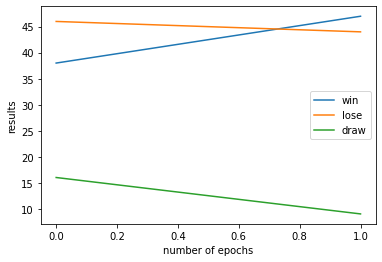

In [19]:
list_serie = [list(d) for d in plot_sum]
win_serie = []
lose_serie = []
draw_serie = []

for i in range(len(list_serie)):
  sample = list_serie[i]
  for j in range(len(sample)):
    if sample[j][0]==1:
      win_serie.append(sample[j][1])
    elif sample[j][0]==-1:
      lose_serie.append(sample[j][1])
    else:
      draw_serie.append(sample[j][1])

plt.plot(win_serie,label='win')
plt.plot(lose_serie,label='lose')
plt.plot(draw_serie,label='draw')
plt.legend()
plt.xlabel('number of epochs')
plt.ylabel('results')

Text(0.5, 0, 'number of epochs')

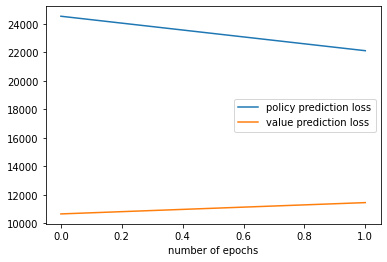

In [20]:
plt.plot(plot_loss,label='policy prediction loss')
plt.plot(plot_value,label='value prediction loss')
plt.legend()
plt.xlabel('number of epochs')

In [21]:
# Search with trained net
tree = Tree(net)
tree.think(State().tictactoe().play('A1 B3 C1 A3 '), 1000, show=True)
#tree.pv(State().tictactoe().play('A1 C1 C3 C2'))

   1 2 3
A O _ X
B _ _ X
C O _ _
record = A1 B3 C1 A3
1.00 sec. best A2. q = -0.6638. n = 88 / 326. pv = A2
2.00 sec. best A2. q = -0.6822. n = 158 / 609. pv = A2
3.00 sec. best A2. q = -0.6850. n = 227 / 867. pv = A2


array([0., 1., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [22]:
print(vs_random(net, n=1000))

{1: 536, -1: 348, 0: 116}


**Playing agiant MuZero**

In [23]:
first_turn = True
turn = first_turn
state = State().tictactoe()
while not state.terminal():
    if turn:
        p, _ = net.predict(state, [])[-1]
        action = sorted([(a, p[a]) for a in state.legal_actions()], key=lambda x:-x[1])[0][0]
    else:
        action = input('Up to you ! Choose an action : ')
        while not (action in [state.action2str(e) for e in state.legal_actions()] ):
              print('Oups try again !available actions are : ',[state.action2str(e) for e in state.legal_actions()])
              action = input( 'Choose an action  : ')

    state.play(action)
    turn = not turn
    print(state)

if state.terminal_reward() == -1:
  print("Hey you won !!!")
elif state.terminal_reward() == 1:
  print("Fuck he got me")
else:
  print("That was close")

   1 2 3
A _ _ _
B _ _ O
C _ _ _
record = B3


KeyboardInterrupt: ignored

# **MuZero VS MuZero**

In [ ]:
# Training of neural net
batch_size = 32
num_steps = 100

def gen_target(ep, k):
    '''Generate inputs and targets for training'''
    # path, reward, observation, action, policy
    turn_idx = np.random.randint(len(ep[0]))
    ps, vs, ax = [], [], []
    for t in range(turn_idx, turn_idx + k + 1):
        if t < len(ep[0]):
            p = ep[4][t]
            a = ep[3][t]
        else: # state after finishing game
            # p is 0 (loss is 0)
            p = np.zeros_like(ep[4][-1])
            # random action selection
            a = np.zeros(np.prod(ep[3][-1].shape), dtype=np.float32)
            a[np.random.randint(len(a))] = 1
            a = a.reshape(ep[3][-1].shape)
        vs.append([ep[1] if t % 2 == 0 else -ep[1]])
        ps.append(p)
        ax.append(a)
        
    return ep[2][turn_idx], ax, ps, vs

def train(episodes, net, opt):
    '''Train neural net'''
    p_loss_sum, v_loss_sum = 0, 0
    p_loss_l = []
    v_loss_l = []
    net.train()
    k = 4
    for _ in range(num_steps):
        x, ax, p_target, v_target = zip(*[gen_target(episodes[np.random.randint(len(episodes))], k) for j in range(batch_size)])
        x = torch.from_numpy(np.array(x))
        ax = torch.from_numpy(np.array(ax))
        p_target = torch.from_numpy(np.array(p_target))
        v_target = torch.FloatTensor(np.array(v_target))

        # Change the order of axis as [time step, batch, ...]
        ax = torch.transpose(ax, 0, 1)
        p_target = torch.transpose(p_target, 0, 1)
        v_target = torch.transpose(v_target, 0, 1)

        p_loss, v_loss = 0, 0

        # Compute losses for k (+ current) steps
        for t in range(k + 1):
            rp = net.representation(x) if t == 0 else net.dynamics(rp, ax[t - 1])
            p, v = net.prediction(rp)
            p_loss += torch.sum(-p_target[t] * torch.log(p))
            v_loss += torch.sum((v_target[t] - v) ** 2)

        p_loss_sum += p_loss.item()
        v_loss_sum += v_loss.item()

        optimizer.zero_grad()
        (p_loss + v_loss).backward()
        optimizer.step()

    num_train_datum = num_steps * batch_size
    print('p_loss %f v_loss %f' % (p_loss_sum / num_train_datum, v_loss_sum / num_train_datum))
    return net,p_loss_sum, v_loss_sum

In [ ]:
# Battle against muzero
def vs_muzero(net, n=100):
    results = {}
    for i in range(n):
        first_turn = i % 2 == 0
        turn = first_turn
        state = State().tictactoe()
        while not state.terminal():
            if turn:
                p, _ = net.predict(state, [])[-1]
                action = sorted([(a, p[a]) for a in state.legal_actions()], key=lambda x:-x[1])[0][0]
            else:
                p, _ = net.predict(state, [])[-1]
                action = sorted([(a, p[a]) for a in state.legal_actions()], key=lambda x:-x[1])[0][0]
            state.play(action)
            turn = not turn
        r = state.terminal_reward() if turn else -state.terminal_reward()
        results[r] = results.get(r, 0) + 1
    return results

In [ ]:
# Main algorithm of MuZero vs MuZero

num_games = 100
num_games_one_epoch = 20
num_simulations = 40

state_ttt = State().tictactoe()
net = Net(state_ttt)
optimizer = optim.SGD(net.parameters(), lr=3e-4, weight_decay=3e-5, momentum=0.8)

# Display battle results as {-1: lose 0: draw 1: win} (for episode generated for training, 1 means that the first player won)
vs_muzero_sum = vs_muzero(net)
print('vs_muzero = ', sorted(vs_muzero_sum.items()))

episodes = []
result_distribution = {1: 0, 0: 0, -1: 0}
plot_sum=[]
plot_loss = []
plot_value = []

for g in range(num_games):
    # Generate one episode
    record, p_targets, features, action_features = [], [], [], []
    #print(state)

    state = State().tictactoe()
    # temperature using to make policy targets from search results
    temperature = 0.7
    while not state.terminal():
        tree = Tree(net)
        p_target = tree.think(state, num_simulations, temperature)
        p_targets.append(p_target)
        features.append(state.feature())
        # Select action with generated distribution, and then make a transition by that action
        p, _ = net.predict(state, [])[-1]
        action = sorted([(a, p[a]) for a in state.legal_actions()], key=lambda x:-x[1])[0][0]
        action_features.append(state.action_feature(action))
        state.play(action)
        record.append(action)
        temperature *= 0.8
    # reward seen from the first turn player
    reward = state.terminal_reward() * (1 if len(record) % 2 == 0 else -1)
    result_distribution[reward] += 1
    episodes.append((record, reward, features, action_features, p_targets))
    if g % num_games_one_epoch == 0:
        print('game ', end='')
    print(g, ' ', end='')

    # Training of neural net
    if (g + 1) % num_games_one_epoch == 0:
        # Show the result distributiuon of generated episodes
        #print('generated = ', sorted(result_distribution.items()))
        net,loss,value = train(episodes, net, optimizer)
        plot_loss.append(loss)
        plot_value.append(value)

        vs_muzero_once = vs_muzero(net)
        #print('vs_muzero = ', sorted(vs_muzero_once.items()), end='')
        #for r, n in vs_muzero_once.items():
            #vs_muzero_sum[r] += n
        #print(' sum = ', sorted(vs_muzero_sum.items()))
        plot_sum.append(vs_muzero_once.items())

        #show_net(net, State().tictactoe())
        #show_net(net, State().play('A1 C1 A2 C2'))
        #show_net(net, State().play('A1 B2 C3 B3 C1'))
        #show_net(net, State().play('B2 A2 A3 C1 B3'))
        #show_net(net, State().play('B2 A2 A3 C1'))
print('finished')

In [ ]:
list_serie = [list(d) for d in plot_sum]
win_serie = []
lose_serie = []
draw_serie = []

for i in range(len(list_serie)):
  sample = list_serie[i]
  for j in range(len(sample)):
    if sample[j][0]==1:
      win_serie.append(sample[j][1])
    elif sample[j][0]==-1:
      lose_serie.append(sample[j][1])
    else:
      draw_serie.append(sample[j][1])

plt.plot(win_serie,label='win')
plt.plot(lose_serie,label='lose')
plt.plot(draw_serie,label='draw')
plt.legend()
plt.xlabel('number of epochs')
plt.ylabel('Results')

In [ ]:
plt.plot(plot_loss,label='policy prediction loss')
plt.legend()
plt.xlabel('number of epochs')

In [ ]:
print(vs_muzero(net, n=1000))

In [ ]:
# Search with trained net
tree = Tree(net)
s = State().tictactoe().play('A1 A3 ')
tree.think(s, 100, show=True)
tree.pv(s)

In [ ]:
# Show outputs from trained net
print('initial state')
show_net(net, State().tictactoe())

print('WIN by put')
show_net(net, State().tictactoe().play('A1 C1 A2 C2'))

print('LOSE by opponent\'s double')
show_net(net, State().tictactoe().play('B2 A2 A3 C1 B3'))

print('WIN through double')
show_net(net, State().tictactoe().play('B2 A2 A3 C1'))

# hard case: putting on A1 will cause double
print('strategic WIN by following double')
show_net(net, State().tictactoe().play('B1 A3'))